In [12]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
train = pd.read_csv('heart1.csv')
train.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
train.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
train.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Well, there are no missing values, any preprocessing is also not required.

Let's highlight the dependent variable in our data, as well as categorical and quantitative variables.

In [8]:
target = ['HeartDisease']
filtered_features = [i for i in train.columns if i not in target]

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'FastingBS', 'ExerciseAngina', 'ST_Slope']
numerical_features = [i for i in filtered_features if i not in categorical_features]

Now, let's divide the data into training and validation samples.

In [9]:
X = train[filtered_features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**So, now we move on to the model. Let's create the first base-line solution using CatBoost as a machine learning model.**

Let's train the model without any configuration:

In [10]:
clf = CatBoostClassifier(cat_features=categorical_features)
clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose = 150, plot=False)
y_pred = clf.predict(X_test)
print('Accuracy_score:', accuracy_score(y_test, y_pred),
      '\nPrecision_score:', precision_score(y_test, y_pred),
      '\nRecall_score:', recall_score(y_test, y_pred),
      '\nF1_score:', f1_score(y_test, y_pred))

Learning rate set to 0.029359
0:	learn: 0.6687249	test: 0.6736164	best: 0.6736164 (0)	total: 163ms	remaining: 2m 42s
150:	learn: 0.2196635	test: 0.3216210	best: 0.3216210 (150)	total: 2.96s	remaining: 16.6s
300:	learn: 0.1579106	test: 0.3180882	best: 0.3156512 (255)	total: 5.45s	remaining: 12.7s
450:	learn: 0.1144876	test: 0.3286620	best: 0.3156512 (255)	total: 8.39s	remaining: 10.2s
600:	learn: 0.0831515	test: 0.3310222	best: 0.3156512 (255)	total: 10.7s	remaining: 7.13s
750:	learn: 0.0632699	test: 0.3368715	best: 0.3156512 (255)	total: 13.5s	remaining: 4.49s
900:	learn: 0.0504272	test: 0.3420727	best: 0.3156512 (255)	total: 16.6s	remaining: 1.82s
999:	learn: 0.0441022	test: 0.3468612	best: 0.3156512 (255)	total: 18.6s	remaining: 0us

bestTest = 0.3156512381
bestIteration = 255

Shrink model to first 256 iterations.
Accuracy_score: 0.875 
Precision_score: 0.9038461538461539 
Recall_score: 0.8785046728971962 
F1_score: 0.8909952606635071


The accuracy of the default CatBoost was 0.875%, f1 score 0.8909% - not bad, but it can be better.

**Let's try to choose parameters such as test_size and scaler, at which the accuracy will be maximum.**

All test_size will be in the range from 0.15 to 0.5, scalers are as follows: StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer(), FunctionTransformer().

In [11]:
test_sizes = np.arange(0.15, 0.51, 0.01).tolist()
scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer(), FunctionTransformer()]
predictions = pd.DataFrame()

In [14]:
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    for scaler in scalers:
        X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
        X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

        clf = CatBoostClassifier(cat_features=categorical_features)
        clf.fit(X_train, y_train,
                eval_set=(X_test, y_test),
                silent=True, plot=False)
        
        # make pickle file for our model
        pickle.dump(clf, open("modelV2.pkl", "wb"))
        
        y_pred = clf.predict(X_test)

        temp_data = pd.DataFrame({
            'test_size' : [test_size],
            'scaler' : [scaler],
            'accuracy' : [accuracy_score(y_test, y_pred)],
            'f1_score' : [f1_score(y_test, y_pred)]
        })

        predictions = pd.concat([predictions, temp_data])

In [15]:
n = 60
predictions = predictions.sort_values('accuracy', ascending=False).head(n)
predictions['index'] = list(range(1,n+1))
predictions.set_index('index', inplace=True)

In [16]:
predictions

,test_size,scaler,accuracy,f1_score
index,,,,
1,0.18,FunctionTransformer(),0.921687,0.930481
2,0.18,QuantileTransformer(),0.921687,0.930481
3,0.18,PowerTransformer(),0.921687,0.930481
4,0.15,PowerTransformer(),0.920290,0.931677
5,0.15,FunctionTransformer(),0.920290,0.931677
6,0.23,QuantileTransformer(),0.919811,0.930612
7,0.15,QuantileTransformer(),0.913043,0.925000
8,0.23,RobustScaler(),0.910377,0.922449
9,0.23,FunctionTransformer(),0.910377,0.921811


As a result, the best combination turned out to be: test_size = 0.18 and scaler = QuantileScaler().

**Let's launch a new CatBoost taking into account the best combination.**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

scaler = QuantileTransformer()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

clf = CatBoostClassifier(cat_features=categorical_features)
clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=150, plot=False)
y_pred = clf.predict(X_test)

# make pickle file for our model
pickle.dump(clf, open("modelV3.pkl", "wb"))
        
        
print('Accuracy_score:', accuracy_score(y_test, y_pred),
      '\nPrecision_score:', precision_score(y_test, y_pred),
      '\nRecall_score:', recall_score(y_test, y_pred),
      '\nF1_score:', f1_score(y_test, y_pred))

Learning rate set to 0.029535
0:	learn: 0.6666835	test: 0.6714268	best: 0.6714268 (0)	total: 20.2ms	remaining: 20.1s
150:	learn: 0.2155843	test: 0.3122401	best: 0.3121735 (149)	total: 2.78s	remaining: 15.6s
300:	learn: 0.1570389	test: 0.2992223	best: 0.2987242 (297)	total: 5.58s	remaining: 12.9s
450:	learn: 0.1131525	test: 0.2959702	best: 0.2951315 (400)	total: 8.43s	remaining: 10.3s
600:	learn: 0.0798600	test: 0.2955972	best: 0.2946351 (511)	total: 11.1s	remaining: 7.4s
750:	learn: 0.0604804	test: 0.2952377	best: 0.2939546 (701)	total: 13.8s	remaining: 4.56s
900:	learn: 0.0472213	test: 0.3006327	best: 0.2939546 (701)	total: 16.9s	remaining: 1.85s
999:	learn: 0.0422803	test: 0.2999560	best: 0.2939546 (701)	total: 18.9s	remaining: 0us

bestTest = 0.2939546458
bestIteration = 701

Shrink model to first 702 iterations.
Accuracy_score: 0.9216867469879518 
Precision_score: 0.9560439560439561 
Recall_score: 0.90625 
F1_score: 0.9304812834224598


The accuracy of the model increased from 0.875 to 0.9216%, which is as much as 4.66, f1_score also increased by 3.95, from 0.8909 to 0.9304%

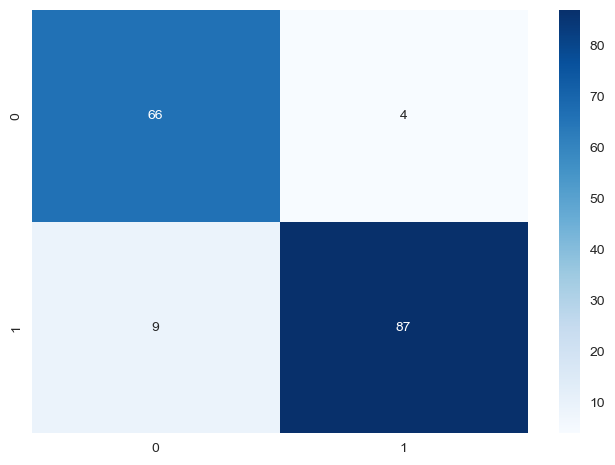

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.show()

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        70
           1       0.96      0.91      0.93        96

    accuracy                           0.92       166
   macro avg       0.92      0.92      0.92       166
weighted avg       0.92      0.92      0.92       166



roc_auc_score: 0.9497023809523809


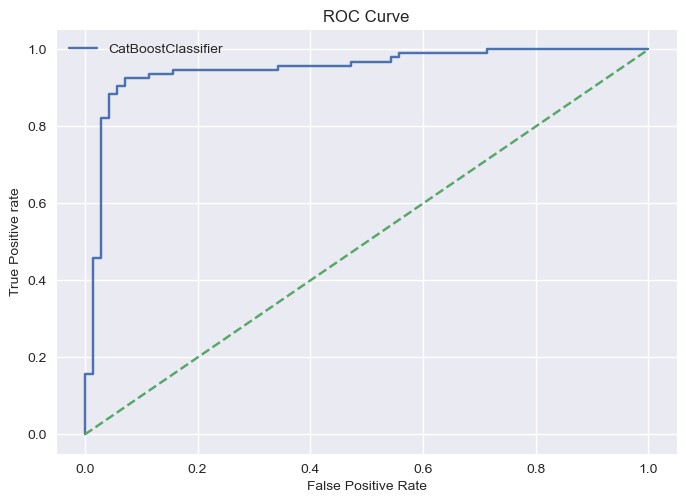

In [22]:
y_pred_prob = clf.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test, y_pred_prob[:,1]))

fpr, tpr, thresh = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='-', label='CatBoostClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

**Metrics have a fairly high score - which indicates the quality of the model.**